<a href="https://colab.research.google.com/github/varJATIN/Ocular-fundus-image-Analysis/blob/main/Seg_using_Ben_processed_Hemmorhage_cstm_arch1_6l_4f_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import sys
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from sklearn.utils import shuffle
from matplotlib.pyplot import imread
from cv2 import resize
import matplotlib.pyplot as plt
import cv2
import scipy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c=tf.keras.layers.BatchNormalization()(c)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    c=tf.keras.layers.BatchNormalization()(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def atten(x,g,F_x,F_g,F_int,kernel_size=(3,3), padding="same", strides=1):
    # upsample lower decoder filters
    us = keras.layers.UpSampling2D((2, 2))(g)
    gate = keras.layers.Conv2D(F_g, kernel_size, padding=padding, strides=strides, activation="relu")(us)
    gate=tf.keras.layers.BatchNormalization()(gate)
    
    # convolve the upsampled decoder filter for F_int filters
    W_g=keras.layers.Conv2D(F_int, kernel_size=1, padding=padding, strides=strides)(gate)
    W_g=tf.keras.layers.BatchNormalization()(W_g)
    
    # convolve encoder output for F_int filters
    W_x=keras.layers.Conv2D(F_int, kernel_size=1, padding=padding, strides=strides)(x)
    W_x=tf.keras.layers.BatchNormalization()(W_x)
    
    # convolve to  attention filter
    psi=tf.keras.activations.relu(W_x+W_g, alpha=0.0, max_value=None, threshold=0)
    psi=keras.layers.Conv2D(F_x, kernel_size=1, padding=padding, strides=strides)(psi)
    psi=tf.keras.activations.sigmoid(tf.keras.layers.BatchNormalization()(psi))
    
    # return the filtered encoder output for concat
    return x*psi

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    us = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(us)
    us = tf.keras.layers.BatchNormalization()(us)
    # here skip is from encoder and x if from dec previous layer 
    filtered_skip=atten(skip,x,filters,filters,filters/2)
    #concat filtrd skip and upsampled us
    concat = keras.layers.Concatenate()([us, filtered_skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c=tf.keras.layers.BatchNormalization()(c)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    c=tf.keras.layers.BatchNormalization()(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c=tf.keras.layers.BatchNormalization()(c)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    c=tf.keras.layers.BatchNormalization()(c) 
    return c

In [ ]:
def UNet_modular(depth=4,f=3,image_size=512):
    """ returns a modular code for the UNet multihead attention with
        deep supervision.
        depth is depth of model excluding bottleneck.
        f is no of filters in first layer.
        image_size is image pixel 
    """
    # define input container with 3 input channels
    input_channels=3
    inputs= keras.layers.Input((image_size, image_size, input_channels))
    pooled_out=inputs
    skip_memory=[]
    filters=[]
    for layer in range(depth):
      filters.append(f*2**layer)
    print(filters)

    for layer in range(depth):
      x,pooled_out=down_block(pooled_out,filters[layer])
      skip_memory.append(x)	

    # bottleneck_factor 
    bn_factor=2**depth
    upsample_out=bottleneck(pooled_out,f*bn_factor)
    upsample_memory=[upsample_out]
    for layer in range(depth):
      upsample_out=up_block(upsample_out,skip_memory[depth-1-layer],filters[depth-1-layer])
      upsample_memory.append(upsample_out)

    #up sample layer
    up=keras.layers.UpSampling2D((2,2))
    #create empty list for storing skip up samples 
    skip_up_list=[]
    # upsample the outputs of upsample layers stored in upsample_memory
    for i in range(depth):
      skip_up=upsample_memory[i]
      for j in range(depth-i):
        skip_up=up(skip_up)
      skip_up_list.append(skip_up)
    skip_up_list.append(upsample_memory[depth])
    deep_supervised = keras.layers.Concatenate()(skip_up_list)
    outputs=keras.layers.Conv2D(1,(1,1),padding="same",activation="sigmoid")(deep_supervised)
    model=keras.models.Model(inputs,outputs)
    return model


In [ ]:
# data
data_location = "/content/drive/My Drive/IDRid/A. Segmentation/1. Original Images/a. Training Set"
train_data = []  # create an empty list
for (dirName, subdirList, fileList) in sorted(os.walk(data_location)):
    for fileName in sorted(fileList):
        if ".jpg" in fileName.lower() :
            train_data.append(os.path.join(dirName,fileName))
 
print(len(train_data))


# groundtruths for hard exudates
target_root_location = "/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set/"
#data_location = "/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set/3. Hard Exudates"
train_data_gt = []  # create an empty list
segs=['1. Microaneurysms','2. Haemorrhages','3. Hard Exudates','4. Soft Exudates']
for seg in segs:
  data_location=target_root_location+seg
  print(data_location)
  seg_mask=[]
  for dirName, subdirList, fileList in sorted(os.walk(data_location)):
      for filename in sorted(fileList):
          if ".tif" in filename.lower() :
              seg_mask.append(os.path.join(dirName,filename))
              #train_data_gt.append(os.path.join(dirName,filename))
  train_data_gt.append(seg_mask)
print(len(train_data_gt));

54
/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set/1. Microaneurysms
/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set/2. Haemorrhages
/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set/3. Hard Exudates
/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set/4. Soft Exudates
4


In [ ]:
def crop_image_from_gray(img, tol=8):
    # If for some reason we only have two channels
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    # If we have a normal RGB images
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img,mask
def preprocess_image(image,label, sigmaX=8):
    IMG_WIDTH=512
    image,mask = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_WIDTH, IMG_WIDTH))
    #print(image.shape,label.shape)
    image = cv2.addWeighted (image,4, cv2.GaussianBlur(image, (0,0) ,sigmaX), -4, 128)
    label = label[:,:][np.ix_(mask.any(1),mask.any(0))]
    return image,label

In [ ]:
train_batch = np.zeros(shape = (len(train_data_gt[1])*5, 512, 512, 3));
train_label = np.zeros(shape = (len(train_data_gt[1])*5, 512, 512, 1));
rot=[-4,-3,-2,-1,1,2,3,4]

for file_index in range(0,len(train_data_gt[1])*5,5):
    #print(file_index)
    # image
    #shift image  by 1 ahead when it reaches 43 index.
    if int(train_data_gt[1][int(file_index/5)][-9:-7])>=43:
      img=imread(train_data[int(file_index/5)+1]) #hence read image from ind 44
    else:
      img=imread(train_data[int(file_index/5)])
    # label
    lbl = cv2.cvtColor(imread(train_data_gt[1][int(file_index/5)]), cv2.COLOR_BGRA2BGR)
    lbl = cv2.cvtColor(lbl, cv2.COLOR_BGR2GRAY) 
    #print(img.shape,lbl.shape)
    img,lbl=preprocess_image(img,lbl)
    train_batch[file_index, :, :,:],train_label[file_index, :, :,:]  = img,np.expand_dims(resize(lbl, (512, 512)), axis = 2)
    #flip
    train_batch[file_index+1, :, :,:]=np.flip(train_batch[file_index, :, :,:],axis=1)
    train_label[file_index+1, :, :,:]=np.flip(train_label[file_index, :, :,:],axis=1)
    #flip
    train_batch[file_index+2, :, :,:]=np.flip(train_batch[file_index, :, :,:],axis=0)
    train_label[file_index+2, :, :,:]=np.flip(train_label[file_index, :, :,:],axis=0)
    #rotate
    train_batch[file_index+3, :, :,:]=np.rot90(np.rot90(train_batch[file_index, :, :,:]))
    train_label[file_index+3, :, :,:]=np.rot90(np.rot90(train_label[file_index, :, :,:]))

    #random rotate
    ang=random.choice(rot)
    train_batch[file_index+4, :, :,:]=scipy.ndimage.rotate(train_batch[file_index, :, :,:],ang,reshape=False)
    train_label[file_index+4, :, :,:]=scipy.ndimage.rotate(train_label[file_index, :, :,:],ang,reshape=False)

train_batch[:,:,:,0]  = (train_batch[:,:,:,0])/255# - train_images[:,:,:,0].min(axis=0)) / (train_images[:,:,:,0].max(axis=0) - train_images[:,:,:,0].min(axis=0)+1e-10)
train_batch[:,:,:,1]  = (train_batch[:,:,:,1])/255# - train_images[:,:,:,1].min(axis=0)) / (train_images[:,:,:,1].max(axis=0) - train_images[:,:,:,1].min(axis=0)+1e-10)
train_batch[:,:,:,2]  = (train_batch[:,:,:,2])/255# - train_images[:,:,:,2].min(axis=0)) / (train_images[:,:,:,2].max(axis=0) - train_images[:,:,:,2].min(axis=0)+1e-10)

train_label  = train_label / np.max(train_label)
mask = train_label[:,:,:,:] > 0.3
train_label[mask] = 1.0
train_label[~mask] = 0.0

print(train_batch.shape)
print(train_label.shape)

(265, 512, 512, 3)
(265, 512, 512, 1)


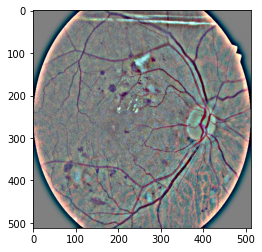

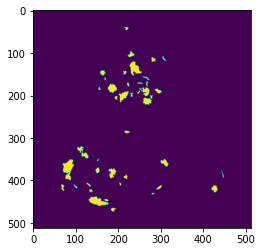

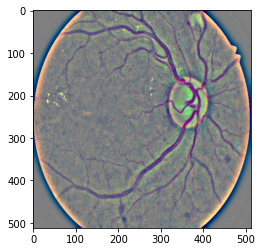

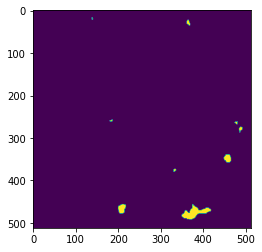

In [ ]:
for i in range(0,10,5):
  plt.imshow(train_batch[44*5+i])
  plt.show()
  plt.imshow(np.squeeze(train_label[44*5+i],axis=2))
  plt.show()

In [ ]:
print(np.max(train_batch),np.max(train_label))

1.2070116761824854 1.0


In [ ]:
from keras import backend as K
def dice_loss(y_true, y_pred, smooth=1):
  intersection = K.sum(y_true * y_pred, axis=[1,2,3])
  union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
  dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
  return 1-dice

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
data_gen_args = dict(rotation_range=10,
                     width_shift_range=1.05,
                     height_shift_range=0.05,
                     zoom_range=[0.95,1],
                     fill_mode='nearest')
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)
seed=2
image_datagen.fit(train_batch, augment=True, seed=seed)
mask_datagen.fit(train_label, augment=True, seed=seed)
image_generator = image_datagen.flow(train_batch,seed=seed,batch_size=4)
mask_generator = mask_datagen.flow(train_label,seed=seed,batch_size=4)
gen=zip(image_generator, mask_generator)

In [ ]:
random.seed = seed
np.random.seed(seed)
tf.seed = seed
tf.random.set_seed(42)
depths=[6]
models=[]
histories=[]
#for f in []:
for depth in depths:
  opt=keras.optimizers.Adam(learning_rate = 0.001,beta_1=0.80)
  model = UNet_modular(depth=depth,f=4) 
  model.compile(optimizer=opt, loss=dice_loss, metrics=[tf.keras.metrics.MeanIoU(num_classes=2)])   
  early_stopping= tf.keras.callbacks.EarlyStopping(monitor='loss',min_delta	=0.001, patience=8)
  rlrop=tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=6,verbose=1,mode='auto', min_delta=0.01) 
  hist = model.fit(gen, steps_per_epoch=len(image_generator), epochs = 200, verbose = 1, callbacks=[early_stopping,rlrop])
  #hist = model.fit(x = train_batch, y = train_label, batch_size = 4, epochs = 200, verbose = 1, callbacks=[early_stopping], validation_split = 8/150, shuffle = True)
  models.append(model)
  histories.append(hist) 

[4, 8, 16, 32, 64, 128]
Epoch 1/200
67/67 [==============================] - 67s 406ms/step - loss: 0.9745 - mean_io_u_1: 0.4921
Epoch 2/200
67/67 [==============================] - 26s 388ms/step - loss: 0.9700 - mean_io_u_1: 0.4819
Epoch 3/200
67/67 [==============================] - 26s 392ms/step - loss: 0.9283 - mean_io_u_1: 0.4854
Epoch 4/200
67/67 [==============================] - 26s 393ms/step - loss: 0.8743 - mean_io_u_1: 0.5095
Epoch 5/200
67/67 [==============================] - 26s 390ms/step - loss: 0.7187 - mean_io_u_1: 0.5597
Epoch 6/200
67/67 [==============================] - 26s 390ms/step - loss: 0.6853 - mean_io_u_1: 0.5559
Epoch 7/200
67/67 [==============================] - 26s 393ms/step - loss: 0.6274 - mean_io_u_1: 0.5778
Epoch 8/200
67/67 [==============================] - 26s 389ms/step - loss: 0.6250 - mean_io_u_1: 0.5841
Epoch 9/200
67/67 [==============================] - 26s 389ms/step - loss: 0.5832 - mean_io_u_1: 0.5951
Epoch 10/200
67/67 [===========

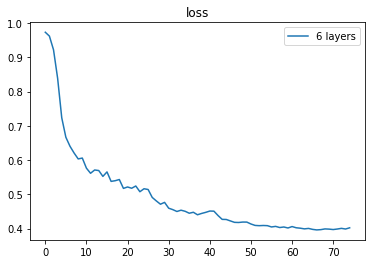

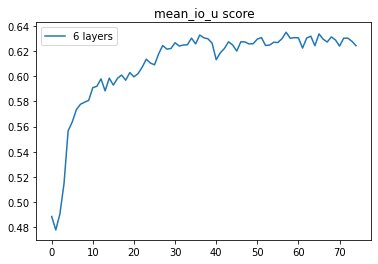

In [ ]:
for i,hist in enumerate(histories):
  plt.plot(hist.history['loss'],label="{} layers".format(depths[i]))
plt.legend()
plt.title('loss')
plt.show()
for i,hist in enumerate(histories):
  plt.plot(hist.history['mean_io_u_{}'.format(str(i+1))],label="{} layers".format(depths[i]))
plt.legend()
plt.title('mean_io_u score')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve,precision_score,recall_score

#test data

In [ ]:

# data
data_location = "/content/drive/My Drive/IDRid/A. Segmentation/1. Original Images/b. Testing Set"
test_data = []  # create an empty list
for (dirName, subdirList, fileList) in sorted(os.walk(data_location)):
    for fileName in sorted(fileList):
        if ".jpg" in fileName.lower() :
            test_data.append(os.path.join(dirName,fileName))
    
print(len(test_data))
target_root_location = "/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/b. Testing Set/"

test_data_gt = []  # create an empty list
segs=['1. Microaneurysms','2. Haemorrhages','3. Hard Exudates','4. Soft Exudates']
for seg in segs:
  data_location=target_root_location+seg
  print(data_location)
  seg_mask=[]
  for dirName, subdirList, fileList in sorted(os.walk(data_location)):
      for filename in sorted(fileList):
          if ".tif" in filename.lower() :
              seg_mask.append(os.path.join(dirName,filename))
              
  test_data_gt.append(seg_mask)
print(len(test_data_gt));

27
/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/b. Testing Set/1. Microaneurysms
/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/b. Testing Set/2. Haemorrhages
/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/b. Testing Set/3. Hard Exudates
/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/b. Testing Set/4. Soft Exudates
4


In [ ]:
test_batch = np.zeros(shape = (len(test_data), 512, 512, 3));
#test_labels_ls=[]
test_label = np.zeros(shape = (len(test_data), 512, 512, 1));

for file_index in range(0,len(test_data)):
    #print(file_index)
    # image
    img=imread(test_data[int(file_index)])
    # label
    lbl = cv2.cvtColor(imread(test_data_gt[1][int(file_index)]), cv2.COLOR_BGRA2BGR)
    lbl = cv2.cvtColor(lbl, cv2.COLOR_BGR2GRAY) 
    img,lbl=preprocess_image(img,lbl)
    test_batch[file_index, :, :,:],test_label[file_index, :, :,:]  = img,np.expand_dims(resize(lbl, (512, 512)), axis = 2)
    #flip
    
test_batch  = test_batch/255
test_label  = test_label / np.max(test_label)

mask = test_label[:,:,:,:] > 0.3
test_label[mask] = 1.0
test_label[~mask] = 0.0

print(test_batch.shape)
print(test_label.shape)

(27, 512, 512, 3)
(27, 512, 512, 1)


(27, 512, 512, 3)
(27, 512, 512, 1)


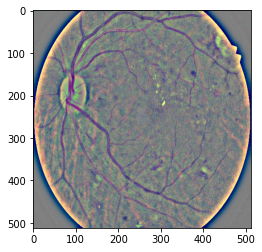

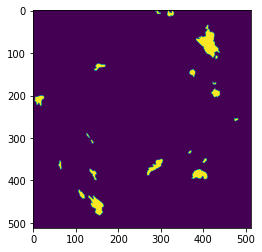

In [ ]:
print(test_batch.shape)
print(test_label.shape)
plt.imshow(test_batch[1])
plt.show()
plt.imshow(np.squeeze(test_label[1]))
plt.show()

6 layers
train  0  test roc 0.8526210158023159
Train  F1 score: 0.000000 Test F1 score: 0.559074
Accuracy: 0.989384
natural threshold train AUPR 0  test AUPR 0.5042721701895148


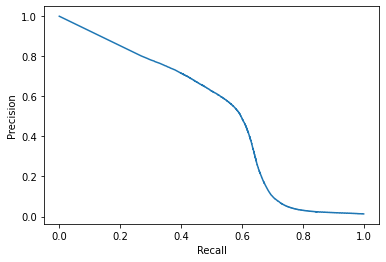

In [ ]:
for j,model in enumerate(models):
  print(depths[j], "layers")
  predicted_test_label=np.zeros(test_label.shape)
  for i in range(27):
  #print(np.expand_dims(test_batch[i],axis=0).shape)
    predicted_test_label[i]=models[j].predict(np.expand_dims(test_batch[i],axis=0))
  #generate the masks
  
  # ROC
  test_auc = roc_auc_score(test_label.reshape(-1),predicted_test_label.reshape(-1))
  #train_auc = roc_auc_score(train_label.reshape(-1),predicted_train_label.reshape(-1))
  print("train ",0," test roc",test_auc)
  
  # F1
  testy, yhat_classes=(test_label.reshape(-1),np.round(predicted_test_label.reshape(-1)))
  test_f1 = f1_score(testy, yhat_classes)
  #testy, yhat_classes=train_label.reshape(-1),np.round(predicted_train_label.reshape(-1))
  #train_f1 = f1_score(testy, yhat_classes)
  train_f1=0
  print('Train  F1 score: %f' % train_f1,'Test F1 score: %f' % test_f1)

  
  #accuracy
  accuracy = accuracy_score(testy, yhat_classes)
  print('Accuracy: %f' % accuracy)
  #AUPR
  
  test_aupr = precision_recall_curve(test_label.reshape(-1),predicted_test_label.reshape(-1))
  train_auc=0
  test_auc=auc(test_aupr[1],test_aupr[0] )
  print("natural threshold train AUPR",train_auc," test AUPR",test_auc)
  
  #plot Precision recall curve
  plt.plot(test_aupr[1],test_aupr[0])
  plt.ylabel('Precision')
  plt.xlabel('Recall')
  plt.show()
  #del predicted_test_label 

(512, 512, 1)


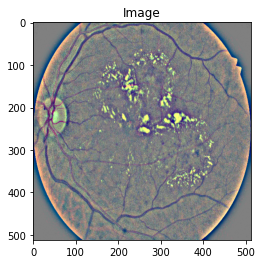

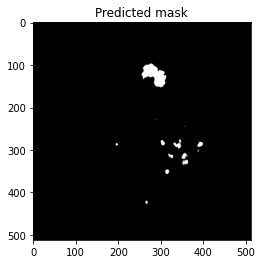

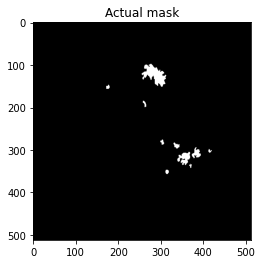

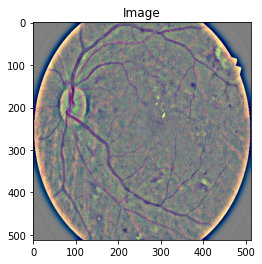

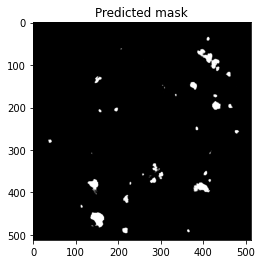

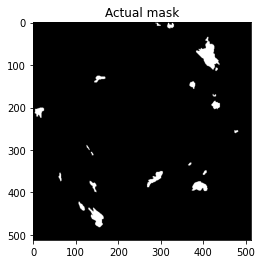

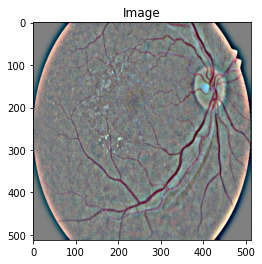

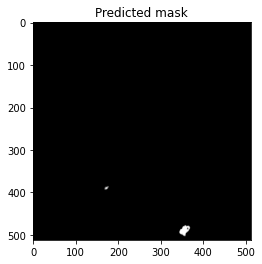

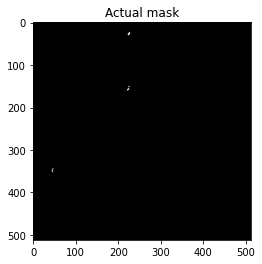

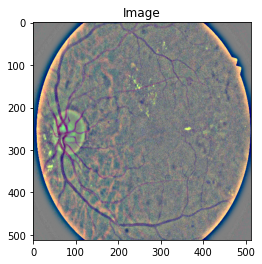

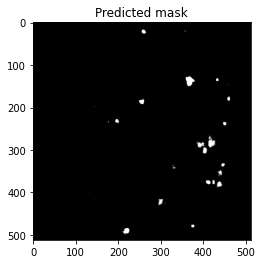

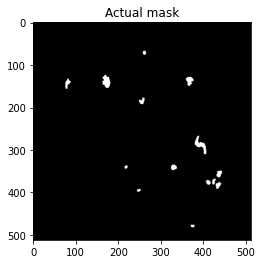

In [ ]:
print(predicted_test_label[0].shape)
for i in range(4):
    plt.imshow(test_batch[i,:,:,:])
    plt.title("Image")
    plt.show()  
    plt.imshow(np.squeeze(predicted_test_label[i,:,:,:], axis = 2),cmap='gray')
    plt.title("Predicted mask")
    plt.show()
    plt.imshow(np.squeeze(test_label[i,:,:,:], axis = 2), cmap='gray')
    plt.title("Actual mask")
    plt.show()

#individaul test scores


In [ ]:
def dice_score(y_true, y_pred, smooth=1):
  intersection = K.sum(y_true * y_pred, axis=[1,2,3])
  union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
  dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
  return dice

In [ ]:
f1_scores=[]
aupr=[]
for i in range(27):
  # F1
  testy, yhat_classes=(np.expand_dims(test_label[i],axis=0),np.expand_dims(predicted_test_label[i],axis=0))
  test_f1 = dice_score(testy, yhat_classes)
  train_f1=0
  #print('Train  F1 score: %f' % train_f1,'Test F1 score: %f' % test_f1)
  f1_scores.append(test_f1)
  #AUPR
  test_aupr = precision_recall_curve(test_label[i].reshape(-1),predicted_test_label[i].reshape(-1))
  train_auc=0
  test_auc=auc(test_aupr[1],test_aupr[0] )
  #print("Train AUPR",train_auc," test AUPR",test_auc)
  aupr.append(test_auc)

median AUPR 0.5218738009648426  median F1 0.5485429896244552


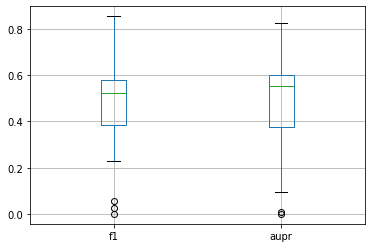

In [ ]:
import pandas as pd
print("median AUPR",np.quantile(aupr,q=0.5)," median F1",np.median(f1_scores))
df = pd.DataFrame(np.array([f1_scores,aupr]).reshape(27,2), columns=['f1','aupr'])
df.plot.box(grid='True')

In [ ]:
 # serialize model to JSON
model_json = model.to_json()
with open("/content/drive/MyDrive/IDRid/Experimental models/seg_HE_ben_sigm8_6l_4f.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("/content/drive/MyDrive/IDRid/Experimental models/seg_HE_ben_sigm8_6l_4f.h5")
print("Saved model to disk")

Saved model to disk
